# Chargement des modules 

In [162]:
# Les classiques
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

# visualisation dynamique
import plotly.express as px

# Modules pour les séries chronologiques
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pmdarima.arima import auto_arima
import os

# Chargement des données et visualisation

In [163]:
path = "/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Série chronologiques_Proïa/projet_electricité/Dataset_CB.csv"


In [164]:
EDF = pd.read_csv(path)

EDF.columns = ["DATE","CONSO"] # renommer col

EDF.DATE = pd.to_datetime(EDF.DATE,format='%d/%m/%y %H:%M') 

print("shape = ",EDF.shape)

EDF.head(4)


shape =  (744, 2)


,DATE,CONSO
0,2023-08-01 00:00:00,522.646044
1,2023-08-01 01:00:00,142.889213
2,2023-08-01 02:00:00,497.052422
3,2023-08-01 03:00:00,110.082063


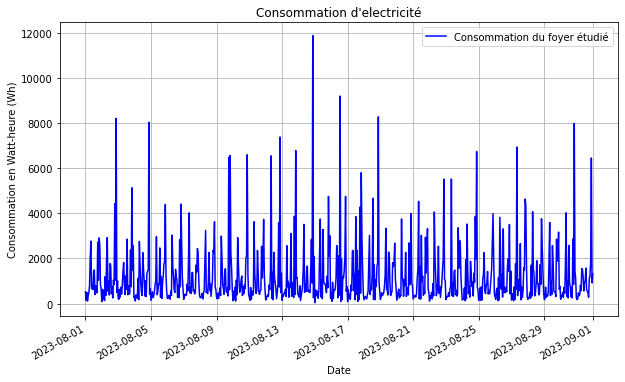

In [35]:
# Tracez les données avec une ligne solide bleue et ajoutez des marqueurs

plt.figure(figsize=(10,6))
plt.plot(EDF.DATE.values, EDF.CONSO.values, linestyle='-', color='b', label='Consommation du foyer étudié')
plt.legend()
plt.title("Consommation d'electricité")
plt.xlabel("Date")
plt.ylabel("Consommation en Watt-heure (Wh)")
plt.gcf().autofmt_xdate() # Personnalisez les axes pour afficher les dates de manière plus lisible
plt.grid(True)
plt.show()

# Passage au log pour atténuer les pics  

In [165]:
EDF['LOGCONSO'] = np.log(EDF.CONSO) # rajouter une colonne au log 
EDF.head()

,DATE,CONSO,LOGCONSO
0,2023-08-01 00:00:00,522.646044,6.258904
1,2023-08-01 01:00:00,142.889213,4.962070
2,2023-08-01 02:00:00,497.052422,6.208695
3,2023-08-01 03:00:00,110.082063,4.701226
4,2023-08-01 04:00:00,333.036926,5.808253


In [279]:
# Créez un graphique interactif avec Plotly Express
fig = px.line(EDF, x='DATE', y='LOGCONSO', labels={'DATE': 'Date', 'LOGCONSO': 'Log consommation'})
fig.update_layout(title="Log-consommation d'énergie du foyer")

# Affichez le graphique interactif
fig.show()

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Au vu de ce graphique, la stationnarité ne semble pas remise en cause, nous allons appuyer cette hypothèse grâce aux tests ADF et KPSS

In [42]:
# On va différentier une fois pour regarder les incréments à une heure près
EDF["diff1"] = EDF.LOGCONSO.diff(1) 

# Créez un graphique interactif avec Plotly Express
fig = px.line(EDF, x='DATE', y="diff1", labels={'DATE': 'Date', 'diff1': ''})
fig.update_layout(title="Différentiation de la Log-consommation d'énergie du foyer")
fig.show()

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Au vu de ce graphique, la stationnarité ne semble pas trop remise en cause, nous allons appuyer cette hypothèse grâce aux tests ADF et KPSS

In [43]:
# On va différentier une fois pour regarder les incréments à 24 heures près
EDF["diff24"] = EDF.LOGCONSO.diff(24) 
fig = px.line(EDF, x='DATE', y="diff24", labels={'DATE': 'Date', 'diff24': ''})
fig.update_layout(title="Différentiation saisonnière de la Log-consommation d'énergie du foyer")
fig.show()

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Au vu de ce graphique, la stationnarité au niveau de la variance du processus semble remise en cause, nous allons voir si les tests ADF et KPSS sont réceptifs à ce genre de non stationnarité. 

# Test de Stationnarité 

## Sans différentiation

In [44]:
# Testons la non-stationnarité 
TestA = adfuller(EDF.LOGCONSO) # Test ADF rejeté
print("ADF p-val : ", TestA[1])

# Testons la stationnarité 
TestK = kpss(EDF.LOGCONSO) # Test KPSS non rejeté 
print("KPSS p-val : ", TestK[1])# Test non rejeté 

ADF p-val :  0.0
KPSS p-val :  0.1


/tmp/ipykernel_15810/2687361320.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Il semblerait que les données suivantes soient stationnaires, nous pouvons ainsi essayer de mettre un modèle mathématique de type (AR, MA, ARIMA, SARMA) que nous avons étudiés durant ce semestre. 

## Avec différentiation 

In [45]:
# Testons la non-stationnarité 
TestA = adfuller(EDF.diff1.dropna()) # Test ADF rejeté
print("ADF p-val : ", TestA[1])

# Testons la stationnarité 
TestK = kpss(EDF.diff1.dropna()) # Test KPSS non rejeté 
print("KPSS p-val : ", TestK[1])# Test non rejeté 

ADF p-val :  6.256435132748781e-22
KPSS p-val :  0.1


/tmp/ipykernel_15810/1720817923.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Il semblerait que les données suivantes soient stationnaires, nous pouvons ainsi essayer de mettre un modèle mathématique de type (AR, MA, ARIMA, SARIMA) que nous avons étudiés durant ce semestre. 

## Avec différentiation saisonnière s=24

In [46]:
# Testons la non-stationnarité 
TestA = adfuller(EDF.diff24.dropna()) # Test ADF rejeté au seuil de 5%
print("ADF p-val : ", TestA[1])

# Testons la stationnarité 
TestK = kpss(EDF.diff24.dropna()) # Test KPSS non rejeté 
print("KPSS p-val : ", TestK[1])# Test non rejeté 

ADF p-val :  0.00022114078230846984
KPSS p-val :  0.1


/tmp/ipykernel_15810/2374260748.py:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Il semblerait que les données suivantes soient stationnaires au vu des tests, cependant nous avons observé une non stationnarité flagrante en variance du processus. Ceci illustre bien la méfiance que nous devons avoir face aux résultats des test ADF et KPSS.

# Étude des corrélations

## Sans différentiation

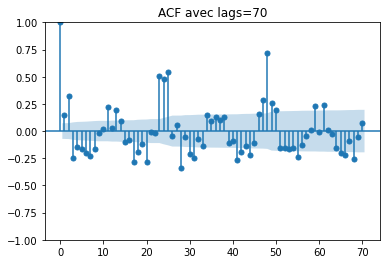

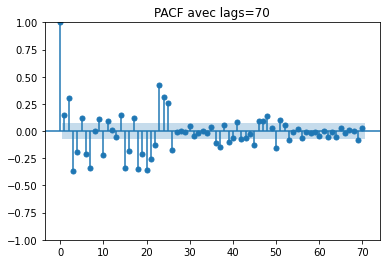

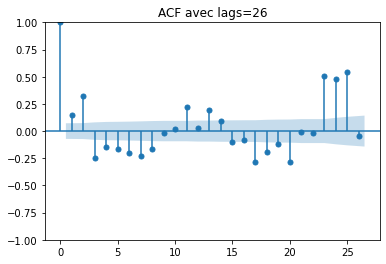

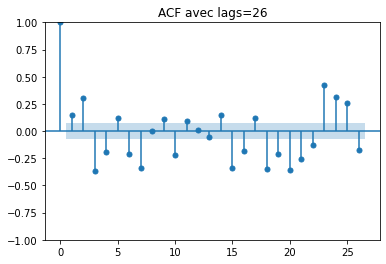

In [47]:
ACF70 = plot_acf(EDF.LOGCONSO, lags=70, alpha=0.05,title="ACF avec lags=70") 
PACF70 = plot_pacf(EDF.LOGCONSO, lags=70, alpha=0.05,title="PACF avec lags=70")

ACF26 = plot_acf(EDF.LOGCONSO, lags=26, alpha=0.05,title="ACF avec lags=26") 

PACF26 = plot_pacf(EDF.LOGCONSO, lags=26, alpha=0.05,title="ACF avec lags=26")


On remarque qu'il y a un regain d'amplitude dans l'ACF au niveau de la valeur h=24 et h= 48, une saisonalité de 24 semble être visible. De plus cette information semble cohérente avec les données car chaque journée contient 24 heures donc 24 observations par jour. L'ACF et la PACF ne nous donnent pas plus d'informations quant aux ordres (p,d,q) et (P,D,Q) pour un modèle de type SARIMA.


## Avec différentiation

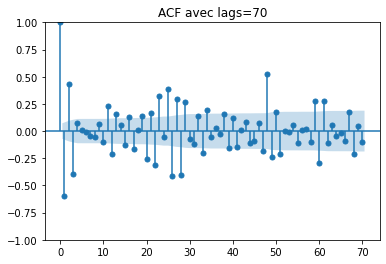

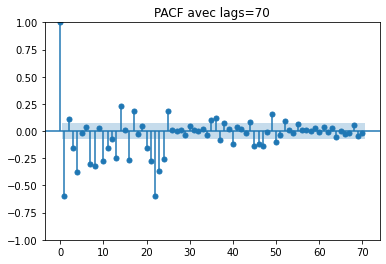

In [38]:
ACF = plot_acf(EDF.diff1.dropna(), lags=70, alpha=0.05,title="ACF avec lags=70") 
PACF = plot_pacf(EDF.diff1.dropna(), lags=70, alpha=0.05,title="PACF avec lags=70")


# Recherche avec la fonction Auto_arima

## Un modèle sans différentiation

In [7]:
auto_arima(EDF.LOGCONSO, start_p=0, start_q=0, seasonal=True, start_P=0, 
           start_Q=0, m=24, d=0, D=0, with_intercept=True, stepwise=True, trace=True)
#force D=d=0 # trace=True pour afficher # stepwise=True passe d'un modèle à l'autre 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2030.245, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=7.85 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1939.821, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=4943.179, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=2022.800, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=1106.752, Time=9.09 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=1595.281, Time=5.93 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=32.69 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=974.376, Time=30.12 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=1682.031, Time=5.65 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=inf, Time=43.18 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=1154.748, Time=26.26 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=837.111, Time=42.04 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=1577.708, Time=21.25 sec
 ARIMA(1,0,1)(1,0,1)[24] inter

ARIMA(order=(5, 0, 0), scoring_args={}, seasonal_order=(1, 0, 2, 24),
      suppress_warnings=True)

## Recherche d'un modèle qui minimise les scores AIC et BIC 

### Modèle 1

In [106]:
Mod1 = SARIMAX(EDF.LOGCONSO, order=(5, 0, 0), seasonal_order=(1, 0, 2, 24), trend=None,
               enforce_stationarity=False, enforce_invertibility=False)
Mod1 = Mod1.fit()
print(Mod1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09498D-01    |proj g|=  7.66078D-01

At iterate    5    f=  5.50346D-01    |proj g|=  4.93444D-01

At iterate   10    f=  4.40659D-01    |proj g|=  4.85079D-01

At iterate   15    f=  3.74918D-01    |proj g|=  3.58471D+00

At iterate   20    f=  3.68720D-01    |proj g|=  4.77678D+00

At iterate   25    f=  3.07768D-01    |proj g|=  4.54615D+00

At iterate   30    f=  3.02238D-01    |proj g|=  4.75369D-01

At iterate   35    f=  3.01694D-01    |proj g|=  2.57073D+00

At iterate   40    f=  3.01431D-01    |proj g|=  4.18126D-02

At iterate   45    f=  3.01172D-01    |proj g|=  1.78037D+00

At iterate   50    f=  2.99857D-01    |proj g|=  2.01052D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                        SARIMAX Results                                        
Dep. Variable:                                LOGCONSO   No. Observations:                  744
Model:             SARIMAX(5, 0, 0)x(1, 0, [1, 2], 24)   Log Likelihood                -223.094
Date:                                 Mon, 08 Jan 2024   AIC                            464.188
Time:                                         20:09:51   BIC                            505.083
Sample:                                              0   HQIC                           480.001
                                                 - 744                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4553      0.035    -12.916      0.000      -0.524      -0

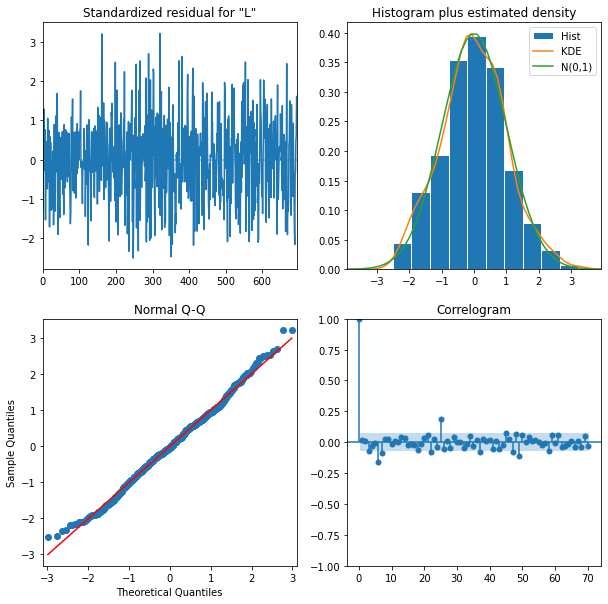

In [50]:
plot1 = Mod1.plot_diagnostics(figsize=(10,10),lags=70)

### Modèle 2

In [277]:
Mod2 = SARIMAX(EDF.LOGCONSO, order=(5, 0, 0), seasonal_order=(2, 0, 2, 24), 
               enforce_stationarity=False, enforce_invertibility=False)
Mod2 = Mod2.fit()
print(Mod2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11376D-01    |proj g|=  7.80335D-01

At iterate    5    f=  4.71615D-01    |proj g|=  2.64844D+00

At iterate   10    f=  4.16560D-01    |proj g|=  1.24870D+00

At iterate   15    f=  3.53180D-01    |proj g|=  2.22325D-01

At iterate   20    f=  3.27983D-01    |proj g|=  7.31144D+00

At iterate   25    f=  2.95668D-01    |proj g|=  1.24907D-01

At iterate   30    f=  2.95135D-01    |proj g|=  1.01250D+00

At iterate   35    f=  2.92002D-01    |proj g|=  1.14762D+00

At iterate   40    f=  2.91787D-01    |proj g|=  3.88562D-01

At iterate   45    f=  2.91002D-01    |proj g|=  7.78476D-02

At iterate   50    f=  2.90992D-01    |proj g|=  6.18667D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                        SARIMAX Results                                        
Dep. Variable:                                LOGCONSO   No. Observations:                  744
Model:             SARIMAX(5, 0, 0)x(2, 0, [1, 2], 24)   Log Likelihood                -216.498
Date:                                 Tue, 09 Jan 2024   AIC                            452.996
Time:                                         18:38:49   BIC                            498.378
Sample:                                              0   HQIC                           470.549
                                                 - 744                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4634      0.036    -12.723      0.000      -0.535      -0

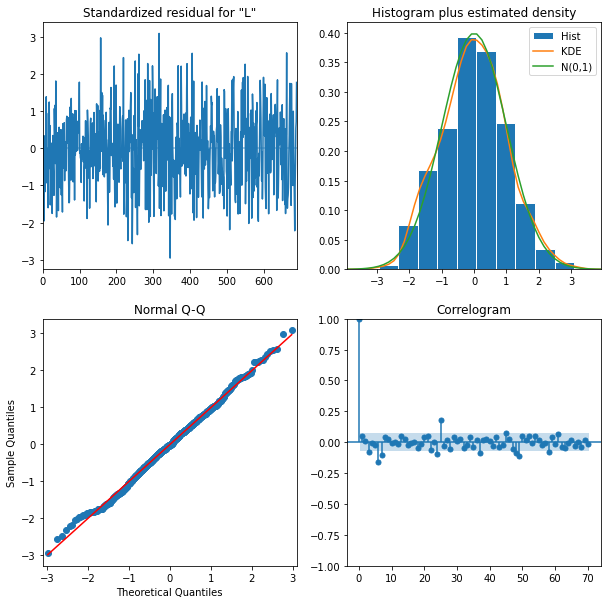

In [49]:
plot2 = Mod2.plot_diagnostics(figsize=(10,10),lags=70)

### Modèle 3

In [19]:
Mod3 = SARIMAX(EDF.LOGCONSO, order=(7, 0, 0), seasonal_order=(2, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod3 = Mod3.fit()
print(Mod3.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09401D-01    |proj g|=  7.75940D-01

At iterate    5    f=  4.66467D-01    |proj g|=  1.06950D+00

At iterate   10    f=  4.04892D-01    |proj g|=  6.35489D-01

At iterate   15    f=  3.61987D-01    |proj g|=  4.08058D-01

At iterate   20    f=  3.02452D-01    |proj g|=  1.32843D+01

At iterate   25    f=  2.88521D-01    |proj g|=  1.11783D-01

At iterate   30    f=  2.87543D-01    |proj g|=  1.43450D+00

At iterate   35    f=  2.80316D-01    |proj g|=  7.23584D+00

At iterate   40    f=  2.73918D-01    |proj g|=  4.87877D-02

At iterate   45    f=  2.73900D-01    |proj g|=  9.28065D-01


/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  2.73734D-01    |proj g|=  8.40201D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     65      1     0     0   8.402D-01   2.737D-01
  F =  0.27373405821391023     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                        SARIMAX Results                                        
Dep. Variable:                                LOGCONSO   No. Observations:                  744
Model:             SARIMAX(7, 0, 0)x(2, 0, [1, 2], 24)   Log Likelihood                -203.658
Date:                                 Mon, 08 Jan 2024   AIC             

In [24]:
Mod4 = SARIMAX(EDF.LOGCONSO, order=(8, 0, 0), seasonal_order=(2, 0, 2, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod4 = Mod4.fit()
print(Mod4.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84130D-01    |proj g|=  7.61102D-01

At iterate    5    f=  4.58572D-01    |proj g|=  7.62104D-01

At iterate   10    f=  3.52029D-01    |proj g|=  2.85949D+00

At iterate   15    f=  3.02449D-01    |proj g|=  5.03669D-01

At iterate   20    f=  2.85172D-01    |proj g|=  2.25300D-01

At iterate   25    f=  2.75729D-01    |proj g|=  1.39960D-01

At iterate   30    f=  2.75592D-01    |proj g|=  3.84990D-01

At iterate   35    f=  2.75312D-01    |proj g|=  3.73224D-01

At iterate   40    f=  2.73742D-01    |proj g|=  1.88576D-01

At iterate   45    f=  2.73195D-01    |proj g|=  1.92873D-01


/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  2.72731D-01    |proj g|=  5.20197D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     65      1     0     0   5.202D-01   2.727D-01
  F =  0.27273078399095563     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                        SARIMAX Results                                        
Dep. Variable:                                LOGCONSO   No. Observations:                  744
Model:             SARIMAX(8, 0, 0)x(2, 0, [1, 2], 24)   Log Likelihood                -202.912
Date:                                 Mon, 08 Jan 2024   AIC             

Au dessus de 7 le coefficient AR n'est plus significatif. 

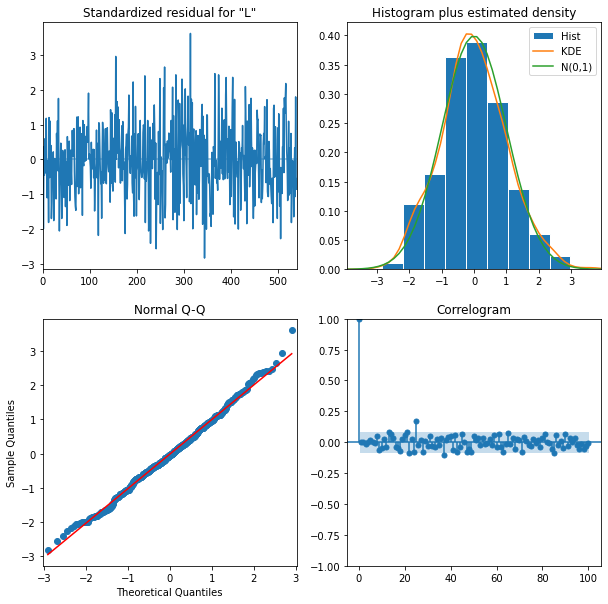

In [276]:
plot3 = Mod3.plot_diagnostics(figsize=(10,10),lags=100)

## Un modèle avec différentiation

In [32]:
auto_arima(EDF.LOGCONSO, start_p=0, start_q=0,max_p = 5,
           max_q=3,seasonal=True, start_P=0, start_Q=0, m=24, d=1, D=0,
           with_intercept=True, stepwise=True, trace=True)
#force d=1 # trace=True pour afficher # stepwise=True passe d'un modèle à l'autre 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=2426.884, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=1565.233, Time=7.84 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=32.88 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=2424.884, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=2094.653, Time=0.15 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=24.06 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=49.23 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=1908.157, Time=7.17 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=85.50 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=2426.909, Time=2.44 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=8.71 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=21.36 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=18.74 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=35.86 sec
 ARIMA(1,1,0)(1,0,0)[24]             : AIC=1563.237,

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 0, 0, 24),
      suppress_warnings=True, with_intercept=False)

### Modèle d1

In [25]:
Mod_d1 = SARIMAX(EDF.LOGCONSO, order=(1, 1, 0), seasonal_order=(1, 0, 0, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod_d1 = Mod_d1.fit()
print(Mod_d1.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38869D+00    |proj g|=  6.06577D-01

At iterate    5    f=  9.97064D-01    |proj g|=  2.22996D-02

At iterate   10    f=  9.96991D-01    |proj g|=  3.70846D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   5.008D-06   9.970D-01
  F =  0.99699106541383664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     S

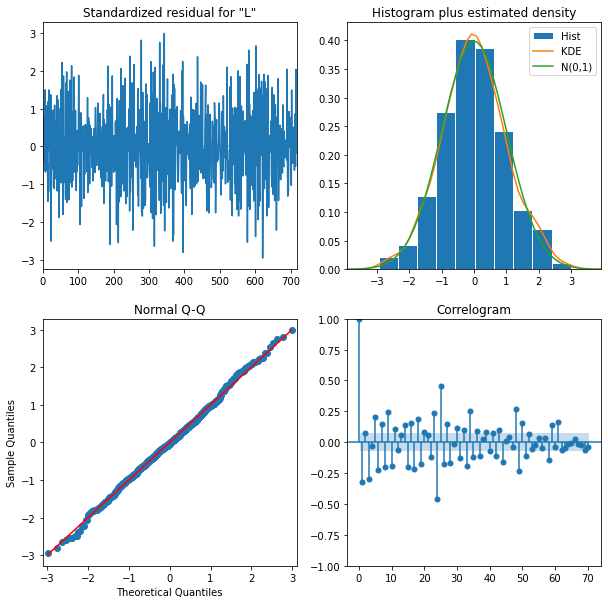

In [51]:
plot_d1 = Mod_d1.plot_diagnostics(figsize=(10,10),lags=70)

### Modèle d2

In [52]:
Mod_d2 = SARIMAX(EDF.LOGCONSO, order=(8, 1, 0), seasonal_order=(2, 0, 1, 24), enforce_stationarity=False, enforce_invertibility=False)
Mod_d2 = Mod_d2.fit()
print(Mod_d2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88876D-01    |proj g|=  5.48028D-01

At iterate    5    f=  5.07786D-01    |proj g|=  1.71050D-01

At iterate   10    f=  3.98628D-01    |proj g|=  2.27772D+00

At iterate   15    f=  3.69821D-01    |proj g|=  5.36544D-01

At iterate   20    f=  3.44816D-01    |proj g|=  4.05160D-01

At iterate   25    f=  3.39891D-01    |proj g|=  1.05092D-01

At iterate   30    f=  3.38141D-01    |proj g|=  4.69337D-02

At iterate   35    f=  3.36147D-01    |proj g|=  1.13637D-01

At iterate   40    f=  3.33031D-01    |proj g|=  2.45615D-01

At iterate   45    f=  3.32144D-01    |proj g|=  4.27766D-02

At iterate   50    f=  3.28273D-01    |proj g|=  3.73982D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                             LOGCONSO   No. Observations:                  744
Model:             SARIMAX(8, 1, 0)x(2, 0, [1], 24)   Log Likelihood                -244.235
Date:                              Mon, 08 Jan 2024   AIC                            512.470
Time:                                      16:03:41   BIC                            566.858
Sample:                                           0   HQIC                           533.512
                                              - 744                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2711      0.037    -34.257      0.000      -1.344      -1.198
ar.L2         -0.71

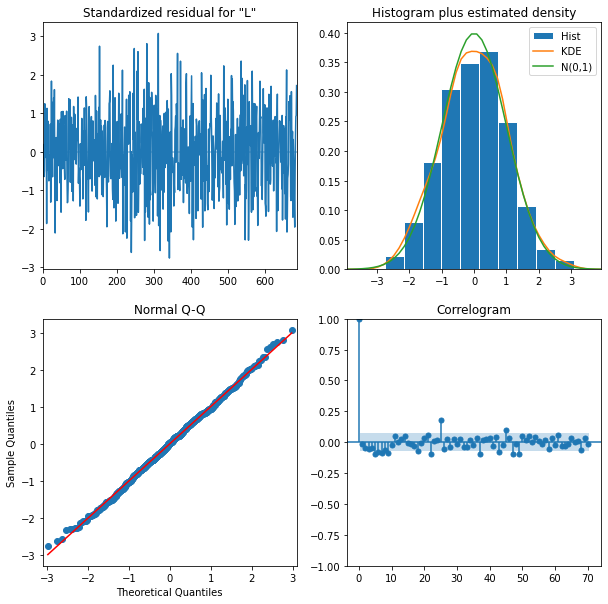

In [28]:
plot_d2 = Mod_d2.plot_diagnostics(figsize=(10,10),lags=70)


## Superposition des courbes pour les différents modèles précédents

In [54]:
EDF['pred_Mod1'] = Mod1.fittedvalues
EDF['pred_Mod2'] = Mod2.fittedvalues
EDF['pred_Mod3'] = Mod3.fittedvalues
EDF['pred_Mod_d1'] = Mod_d1.fittedvalues
EDF['pred_Mod_d2'] = Mod_d2.fittedvalues

In [55]:
EDF

,DATE,CONSO,LOGCONSO,diff1,diff24,pred_Mod1,pred_Mod2,pred_Mod3,pred_Mod_d1,pred_Mod_d2
0,2023-08-01 00:00:00,522.646044,6.258904,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-08-01 01:00:00,142.889213,4.962070,-1.296835,NaN,-2.849658,-2.900174,-2.740857,3.430244,2.281158
2,2023-08-01 02:00:00,497.052422,6.208695,1.246626,NaN,-0.238840,-0.470378,-0.238514,6.134258,5.040037
3,2023-08-01 03:00:00,110.082063,4.701226,-1.507469,NaN,-2.771503,-3.174849,-3.311506,5.081891,3.758533
4,2023-08-01 04:00:00,333.036926,5.808253,1.107027,NaN,-2.047022,-2.687484,-2.823539,6.063803,5.267583
...,...,...,...,...,...,...,...,...,...,...
739,2023-08-31 19:00:00,1216.824530,7.104000,0.092180,0.360467,7.231726,7.423981,7.518964,6.516330,7.282463
740,2023-08-31 20:00:00,1867.397655,7.532301,0.428301,-1.453254,7.629942,7.661778,7.638395,7.890831,7.404812
741,2023-08-31 21:00:00,6456.590007,8.772857,1.240555,1.495892,8.624884,8.600135,8.610959,7.387698,8.468995
742,2023-08-31 22:00:00,915.149345,6.819087,-1.953769,-0.200981,6.629533,6.589223,6.632156,6.277482,6.509329


In [30]:

# Créez un graphique interactif avec Plotly Express pour la première courbe
fig = px.line(EDF[EDF.index >= 50], x='DATE', y='LOGCONSO', labels={'LOGCONSO': 'Log consommation'},
              color_discrete_sequence=['blue'])
# Ajoutez la deuxième courbe avec une couleur différente
fig.add_trace(px.line(EDF[EDF.index >= 50], x='DATE', y='pred_Mod1',
                      color_discrete_sequence=['red']).data[0])

# Mettez à jour le layout avec le titre
fig.update_layout(title="Log-consommation d'énergie du foyer avec superposition du modèle 1")

# Affichez le graphique interactif
fig.show()

# Créez un graphique interactif avec Plotly Express pour la première courbe
fig = px.line(EDF[EDF.index >= 50], x='DATE', y='LOGCONSO',
              labels={'LOGCONSO': 'Log consommation'}, color_discrete_sequence=['blue'])
# Ajoutez la deuxième courbe avec une couleur différente
fig.add_trace(px.line(EDF[EDF.index >= 50], x='DATE', y='pred_Mod2',
                      color_discrete_sequence=['red']).data[0])

# Mettez à jour le layout avec le titre
fig.update_layout(title="Log-consommation d'énergie du foyer avec superposition du modèle 2")

# Affichez le graphique interactif
fig.show()


# Créez un graphique interactif avec Plotly Express pour la première courbe
fig = px.line(EDF[EDF.index >= 50], x='DATE', y='LOGCONSO',
              labels={'LOGCONSO': 'Log consommation'}, color_discrete_sequence=['blue'])
# Ajoutez la deuxième courbe avec une couleur différente
fig.add_trace(px.line(EDF[EDF.index >= 50], x='DATE', y='pred_Mod3',
                      color_discrete_sequence=['red']).data[0])

# Mettez à jour le layout avec le titre
fig.update_layout(title="Log-consommation d'énergie du foyer avec superposition du modèle 3")

# Affichez le graphique interactif
fig.show()

# Créez un graphique interactif avec Plotly Express pour la première courbe
fig = px.line(EDF[EDF.index >= 50], x='DATE', y='LOGCONSO',
              labels={'LOGCONSO': 'Log consommation'}, color_discrete_sequence=['blue'])
# Ajoutez la deuxième courbe avec une couleur différente
fig.add_trace(px.line(EDF[EDF.index >= 50], x='DATE', y='pred_Mod_d2',
                      color_discrete_sequence=['red']).data[0])

# Mettez à jour le layout avec le titre
fig.update_layout(title="Log-consommation d'énergie du foyer avec superposition du modèle d2")

# Affichez le graphique interactif
fig.show()


/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Les quatre modèles suivants semblent bien coller aux données fournies, nous pouvons maintenant choisir le plus performant à l'aide de la Cross Validation pour proposer une prédiction sur les 7 prochains jours. 

## Cross Validation 

In [167]:
EDF = pd.read_csv(path)

EDF.columns = ["DATE","CONSO"] # renommer col

EDF.DATE = pd.to_datetime(EDF.DATE,format='%d/%m/%y %H:%M') 

print("shape = ",EDF.shape)

EDF.head(4)

EDF['LOGCONSO'] = np.log(EDF.CONSO) # rajouter une colonne au log 
EDF

shape =  (744, 2)


,DATE,CONSO,LOGCONSO
0,2023-08-01 00:00:00,522.646044,6.258904
1,2023-08-01 01:00:00,142.889213,4.962070
2,2023-08-01 02:00:00,497.052422,6.208695
3,2023-08-01 03:00:00,110.082063,4.701226
4,2023-08-01 04:00:00,333.036926,5.808253
...,...,...,...
739,2023-08-31 19:00:00,1216.824530,7.104000
740,2023-08-31 20:00:00,1867.397655,7.532301
741,2023-08-31 21:00:00,6456.590007,8.772857
742,2023-08-31 22:00:00,915.149345,6.819087


### Train_test_split

In [168]:
M = len(EDF) - int(np.floor(0.2*len(EDF))) 
print(M)
#Construire une partie train et une partie test avec 20% des données 
EDF_Train = EDF.iloc[:M]
EDF_Test = EDF.iloc[M:]

596


In [169]:
EDF_Test

,DATE,CONSO,LOGCONSO
596,2023-08-25 20:00:00,2789.791163,7.933722
597,2023-08-25 21:00:00,3990.209681,8.291599
598,2023-08-25 22:00:00,1947.497008,7.574300
599,2023-08-25 23:00:00,420.785554,6.042123
600,2023-08-26 00:00:00,294.629097,5.685717
...,...,...,...
739,2023-08-31 19:00:00,1216.824530,7.104000
740,2023-08-31 20:00:00,1867.397655,7.532301
741,2023-08-31 21:00:00,6456.590007,8.772857
742,2023-08-31 22:00:00,915.149345,6.819087


### Entrainement de 4 modèles choisis 

In [170]:
Mod1 = SARIMAX(EDF_Train.LOGCONSO, order=(5, 0, 0), seasonal_order=(1, 0, 2, 24),
               enforce_stationarity=False, enforce_invertibility=False)
Mod1 = Mod1.fit()

Mod2 = SARIMAX(EDF_Train.LOGCONSO, order=(5, 0, 0), seasonal_order=(2, 0, 2, 24),
               enforce_stationarity=False, enforce_invertibility=False)
Mod2 = Mod2.fit()

Mod3 = SARIMAX(EDF_Train.LOGCONSO, order=(7, 0, 0), seasonal_order=(2, 0, 2, 24), 
               enforce_stationarity=False, enforce_invertibility=False)
Mod3 = Mod3.fit()

Mod4 = SARIMAX(EDF_Train.LOGCONSO, order=(8, 1, 0), seasonal_order=(2, 0, 1, 24),
               enforce_stationarity=False, enforce_invertibility=False)
Mod4 = Mod4.fit()

## Stocker les modèles dans un dictionnaire

Mod = {"Mod1":Mod1,"Mod2":Mod2,"Mod3":Mod3,"Mod4":Mod4 } 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99010D-01    |proj g|=  7.57435D-01

At iterate    5    f=  4.64868D-01    |proj g|=  2.47866D+00

At iterate   10    f=  3.84304D-01    |proj g|=  2.86384D+00

At iterate   15    f=  3.20426D-01    |proj g|=  2.36450D+01

At iterate   20    f=  3.07808D-01    |proj g|=  3.85121D+00

At iterate   25    f=  2.90953D-01    |proj g|=  3.80244D+00

At iterate   30    f=  2.90059D-01    |proj g|=  1.36154D+00

At iterate   35    f=  2.89708D-01    |proj g|=  4.09389D-01

At iterate   40    f=  2.89642D-01    |proj g|=  5.27882D-02

At iterate   45    f=  2.89629D-01    |proj g|=  2.33643D-02

At iterate   50    f=  2.89614D-01    |proj g|=  2.69535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94713D-01    |proj g|=  7.68194D-01

At iterate    5    f=  4.46712D-01    |proj g|=  3.24133D-01

At iterate   10    f=  3.73669D-01    |proj g|=  8.94820D+00

At iterate   15    f=  3.38058D-01    |proj g|=  6.15563D-01

At iterate   20    f=  2.85814D-01    |proj g|=  1.00078D+01

At iterate   25    f=  2.77760D-01    |proj g|=  6.37568D-02

At iterate   30    f=  2.77087D-01    |proj g|=  8.96571D-01

At iterate   35    f=  2.73801D-01    |proj g|=  1.33636D-01

At iterate   40    f=  2.73706D-01    |proj g|=  4.13059D-02

At iterate   45    f=  2.73601D-01    |proj g|=  8.83967D-01


/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  2.72265D-01    |proj g|=  3.60265D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     63      1     0     0   3.603D-02   2.723D-01
  F =  0.27226494762556286     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92094D-01    |proj g|=  7.63345D-01

At iterate    5    f=  4.16635D-01    |proj g|=  1.66645D+00

At iterate   10    f=  3.79168D-01   

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  2.56182D-01    |proj g|=  2.96502D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   2.965D-01   2.562D-01
  F =  0.25618238186708203     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93710D-01    |proj g|=  4.82975D-01

At iterate    5    f=  5.11759D-01    |proj g|=  2.32870D-01

At iterate   10    f=  4.03545D-01   

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  3.19447D-01    |proj g|=  1.49401D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   1.494D-01   3.194D-01
  F =  0.31944718221013846     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


### Évaluation des modèles avec des métriques usuelles

In [73]:
Mod["Mod1"].get_forecast(steps=len(EDF_Test)).summary_frame(alpha=0.05).keys()

Index(['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper'], dtype='object', name='LOGCONSO')

## Sur les données au Log

In [173]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    """Renvoie un pourcentage moyen d'erreur entre les vraies valeurs et les prédictions """
    y_true, y_pred = np.array(y_true), np.array(y_pred) #convertir au format array
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  


MAE = [] ## l'écart absolue moyen 
MSE = [] ## la norme2 au carré moyenne
RMSE = []
MAPE = []

for i in range(1,5):
    """Rajoute une colonne prédiction pour chaque modèle et stock les métriques de validations"""
    
    EDF_Test[f"val_{i}"] = Mod[f"Mod{i}"].get_forecast(steps=len(EDF_Test)).summary_frame(alpha=0.05)['mean']
    #mean représente la meilleure estimation de chaque période
    MAE.append(mean_absolute_error(EDF_Test.LOGCONSO, EDF_Test[f"val_{i}"]) )
    MSE.append(mean_squared_error(EDF_Test.LOGCONSO, EDF_Test[f"val_{i}"]) )
    RMSE.append(mean_squared_error(EDF_Test.LOGCONSO, EDF_Test[f"val_{i}"],squared=False) )
    MAPE.append(mean_absolute_percentage_error(EDF_Test.LOGCONSO, EDF_Test[f"val_{i}"]) )
    
    
    
    

/tmp/ipykernel_15810/1462719060.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15810/1462719060.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15810/1462719060.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

## Sur les données avec passage à l'exp

In [193]:

MAE1 = [] ## l'écart absolue moyen 
MSE1 = [] ## la norme2 au carré moyenne
RMSE1 = []
MAPE1 = []

for i in range(1,5):
    """Rajoute une colonne prédiction pour chaque modèle et stock les métriques de validations"""
    
    EDF_Test[f"val_exp{i}"] = np.exp(Mod[f"Mod{i}"].get_forecast(steps=len(EDF_Test)).summary_frame(alpha=0.05)['mean']
                                     +Mod[f"Mod{i}"].params["sigma2"]/2)
    #mean représente la meilleure estimation de chaque période
    MAE1.append(mean_absolute_error(EDF_Test.CONSO, EDF_Test[f"val_exp{i}"]) )
    MSE1.append(mean_squared_error(EDF_Test.CONSO, EDF_Test[f"val_exp{i}"]) )
    RMSE1.append(mean_squared_error(EDF_Test.CONSO, EDF_Test[f"val_exp{i}"],squared=False) )
    MAPE1.append(mean_absolute_percentage_error(EDF_Test.CONSO, EDF_Test[f"val_exp{i}"]) )
    

/tmp/ipykernel_15810/4058766606.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15810/4058766606.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15810/4058766606.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1

In [194]:
EDF_Test.head(5)

,DATE,CONSO,LOGCONSO,val_exp1,val_exp2,val_exp3,val_exp4,val_1,val_2,val_3,val_4
596,2023-08-25 20:00:00,2789.791163,7.933722,1624.389878,1629.588951,1665.508527,1614.771569,7.346593,7.348657,7.373237,7.335164
597,2023-08-25 21:00:00,3990.209681,8.291599,5233.517739,5005.995358,5020.073489,5037.519473,8.516545,8.470966,8.476551,8.472884
598,2023-08-25 22:00:00,1947.497008,7.574300,819.634774,850.045620,843.339294,856.909432,6.662565,6.697864,6.692721,6.701547
599,2023-08-25 23:00:00,420.785554,6.042123,756.884070,718.223462,663.115417,705.827171,6.582916,6.529355,6.452301,6.507585
600,2023-08-26 00:00:00,294.629097,5.685717,187.620215,176.405297,183.159721,194.259237,5.188126,5.125359,5.165710,5.217408


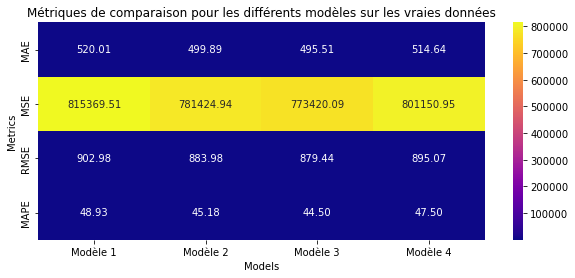

In [195]:
Matrix_exp = np.array([MAE1,MSE1,RMSE1,MAPE1]) # créer une matrice avec le

plt.figure(figsize=(10, 4))
ax = sns.heatmap(Matrix_exp, annot=True, fmt=".2f", cmap="plasma",
                 xticklabels=['Modèle 1', 'Modèle 2','Modèle 3','Modèle 4'],
                 yticklabels=['MAE', 'MSE', 'RMSE', 'MAPE'])

plt.title("Métriques de comparaison pour les différents modèles sur les vraies données")
plt.xlabel("Models")
plt.ylabel("Metrics")

plt.show()

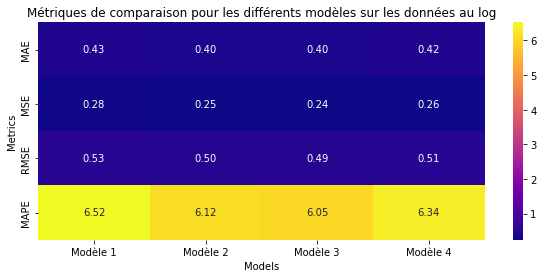

In [180]:
Matrix = np.array([MAE,MSE,RMSE,MAPE]) # créer une matrice avec le

plt.figure(figsize=(10, 4))
ax = sns.heatmap(Matrix, annot=True, fmt=".2f", cmap="plasma",
                 xticklabels=['Modèle 1', 'Modèle 2','Modèle 3','Modèle 4'],
                 yticklabels=['MAE', 'MSE', 'RMSE', 'MAPE'])

plt.title("Métriques de comparaison pour les différents modèles sur les données au log")
plt.xlabel("Models")
plt.ylabel("Metrics")

plt.show()

Le choix du modèle 3 semble mieux coller aux données test sur la partie "forcast_test". Nous allons finalement choisir ce modèle pour faire nos prédictions sur les 7 prochains jours. Nous remarquons grâce à la métrique MAPE que le modèle 3 effectue une erreur de 6.05\% en moyenne par rapport aux vraies données passées au log. 

# Prédictions pour les 7 prochains jours 

### Entrainement du meilleur modèle

In [184]:
Best_Mod = SARIMAX(EDF.LOGCONSO, order=(7, 0, 0), seasonal_order=(2, 0, 2, 24),trend=None,
                   enforce_stationarity=False, enforce_invertibility=False)
Best_Mod = Best_Mod.fit()
print(Best_Mod.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09401D-01    |proj g|=  7.75940D-01

At iterate    5    f=  4.66467D-01    |proj g|=  1.06950D+00

At iterate   10    f=  4.04892D-01    |proj g|=  6.35489D-01

At iterate   15    f=  3.61987D-01    |proj g|=  4.08058D-01

At iterate   20    f=  3.02452D-01    |proj g|=  1.32843D+01

At iterate   25    f=  2.88521D-01    |proj g|=  1.11783D-01

At iterate   30    f=  2.87543D-01    |proj g|=  1.43450D+00

At iterate   35    f=  2.80316D-01    |proj g|=  7.23584D+00

At iterate   40    f=  2.73918D-01    |proj g|=  4.87877D-02

At iterate   45    f=  2.73900D-01    |proj g|=  9.28065D-01

At iterate   50    f=  2.73734D-01    |proj g|=  8.40201D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/ibotcazou/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                        SARIMAX Results                                        
Dep. Variable:                                LOGCONSO   No. Observations:                  744
Model:             SARIMAX(7, 0, 0)x(2, 0, [1, 2], 24)   Log Likelihood                -203.658
Date:                                 Tue, 09 Jan 2024   AIC                            431.316
Time:                                         09:29:59   BIC                            485.739
Sample:                                              0   HQIC                           452.369
                                                 - 744                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4379      0.039    -11.310      0.000      -0.514      -0

<Figure size 720x720 with 0 Axes>

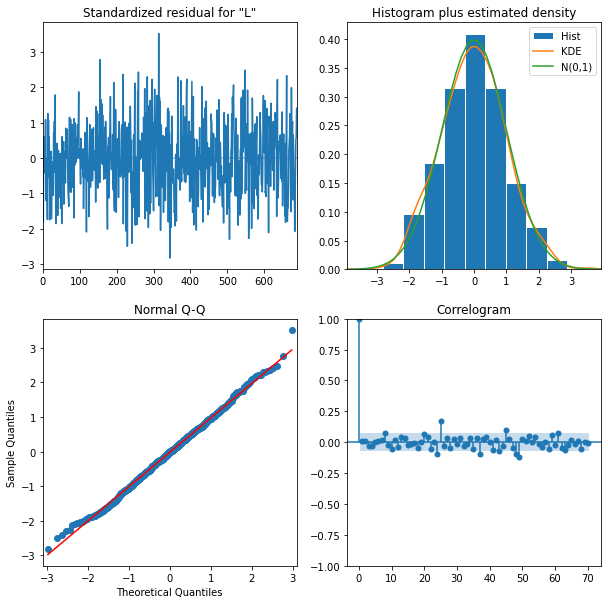

In [185]:
plt.figure(figsize=(10,10))
plot_best = Best_Mod.plot_diagnostics(figsize=(10,10),lags=70)

### Étude des résidus

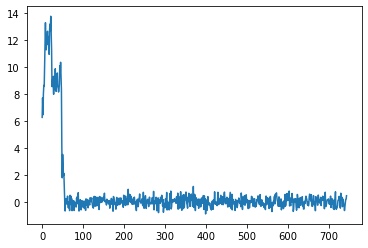

<AxesSubplot:>

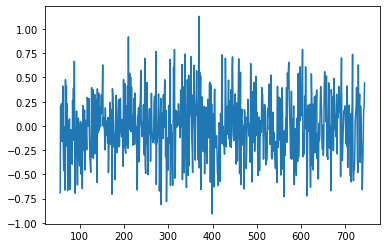

In [186]:
Best_Mod.resid.plot() #Récupère les résidus après entrînement du modèle
plt.show()
## Il y a un caractère AR seasonal d'ordre 2 donc il est cohérent de regarder
#les résidus pour un indice plus grand que 2*24
Res = Best_Mod.resid[Best_Mod.resid.index>55].values
Best_Mod.resid[Best_Mod.resid.index>55].plot()

In [271]:
# Coup d'oeil sur les résidus # Test de Ljung-Box au lag 

TestLB = sm.stats.acorr_ljungbox(Res, lags=[24]) 
print("LB p-val : ", TestLB["lb_pvalue"])

# Test de Lilliefors de normalité un peu comme
#le test de Shapiro mais dans un autre module 

TestN = sm.stats.diagnostic.lilliefors(Res) 
print("Norm p-val : ", TestN[1])

LB p-val :  24    0.413278
Name: lb_pvalue, dtype: float64
Norm p-val :  0.99


* En prenant un lags de 24 on a un non rejet de H0:"Les résidus sont un bruit blanc"

* Nous avons aussi un non rejet de l'hypothèse de Normalité pour les résidus

Nous allons utiliser cette prédiction en prenant l'hyposthèse de normalité des résidus dans celle-ci. 

### Représentation graphique avec la documentation du cours 

In [251]:
# Objet Predicteur
Pred = Best_Mod.get_forecast(steps=7*24).summary_frame(alpha=0.05) # Avec des intervalles de confiance à 95%

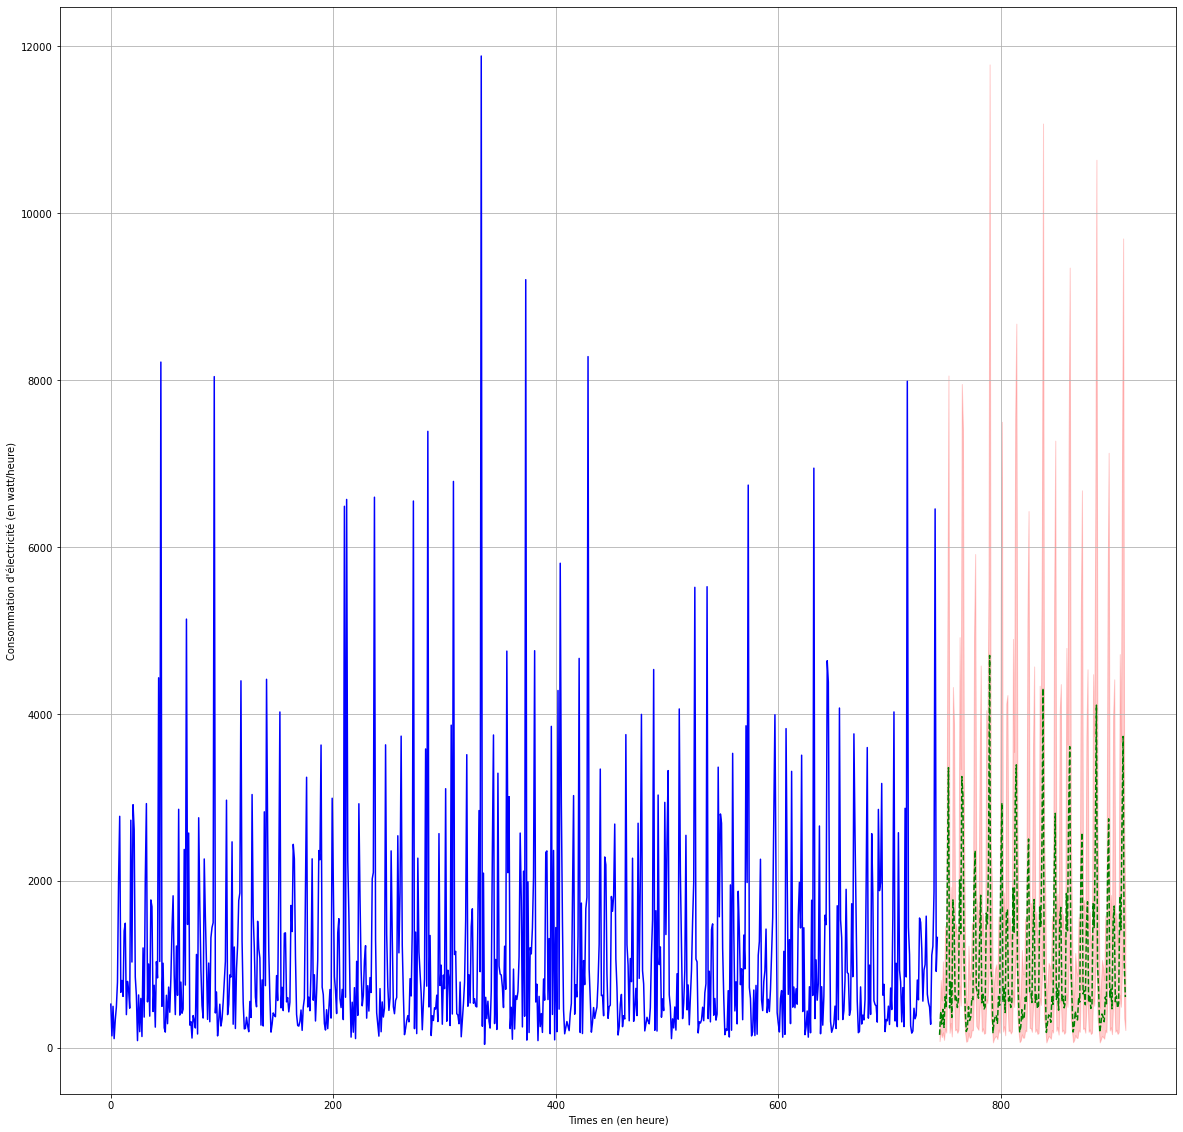

In [252]:
n = len(EDF.CONSO) #taille de la série

plt.figure(figsize=(20,20))
plt.plot(EDF.CONSO.values, color="blue") # la vraie série
## Ne pas oublier sachant que nos résidus semblent suivre une loi normale centrée réduite de multiplier
## par l'estimateur de l'espérance de exp(\Epsilon) (voir page 48 du cours)
plt.plot(range(n+1, n+7*24+1), np.exp(Pred['mean'].values + Best_Mod.params["sigma2"]/2), 
         linestyle='--', color="green") #Mod01F.params[5] correspond à l'estimateur de variance des résidus

plt.fill_between(range(n+1, n+7*24+1), np.exp(Pred['mean_ci_lower']),
                 np.exp(Pred['mean_ci_upper']), color='red', alpha=0.2)
plt.xlabel("Times en (en heure)")
plt.ylabel("Consommation d'électricité (en watt/heure)")
plt.grid()

### Représentation graphique intéractive avec plotly

In [253]:
pred_dates = pd.date_range(start='2023-09-01 00:00:00', periods=7*24, freq='H')  #Le temps futur
predictions = np.exp(Pred['mean'].values + Best_Mod.params["sigma2"]/2)  # les prédictions à venir

# Créer le graphique Plotly
fig = px.line(EDF, x='DATE', y='CONSO',
              labels={'CONSO': "Consommation d'électricité"})

# Ajouter les prédictions
fig.add_scatter(x=pred_dates, y=predictions, mode='lines',
                name='Prédictions', line=dict(color='green', dash='dot'))

# Ajouter la zone de confiance

##Zone supérieure
fig.add_scatter(x=pred_dates, y=np.exp(Pred['mean_ci_lower']), fill='tonexty',
                mode='lines', line=dict(color='lightgrey'), showlegend=False)
##Zone inférieure
fig.add_scatter(x=pred_dates, y=np.exp(Pred['mean_ci_upper']),
                fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False)

# Mettre à jour le layout
fig.update_layout(title="Consommation d'électricité avec prédictions",
                  xaxis_title='Temps (en heure)',
                  yaxis_title='Consommation (en watt/heure)')

# Afficher le graphique
fig.show()

/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [258]:
df = pd.DataFrame({})
predictions

df.index = pred_dates
df.index.name = 'Unnamed: 0'
df["'Conso'"] = predictions
df

,'Conso'
Unnamed: 0,
2023-09-01 00:00:00,154.659654
2023-09-01 01:00:00,434.328758
2023-09-01 02:00:00,282.889772
2023-09-01 03:00:00,460.178193
2023-09-01 04:00:00,244.757495
...,...
2023-09-07 19:00:00,1411.102444
2023-09-07 20:00:00,2703.686574
2023-09-07 21:00:00,3730.974413


In [274]:
df.to_csv('/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Série chronologiques_Proïa/projet_electricité/predictions.csv')



# Seconde approche avec un decompose classique de EDF.LONGCONSO

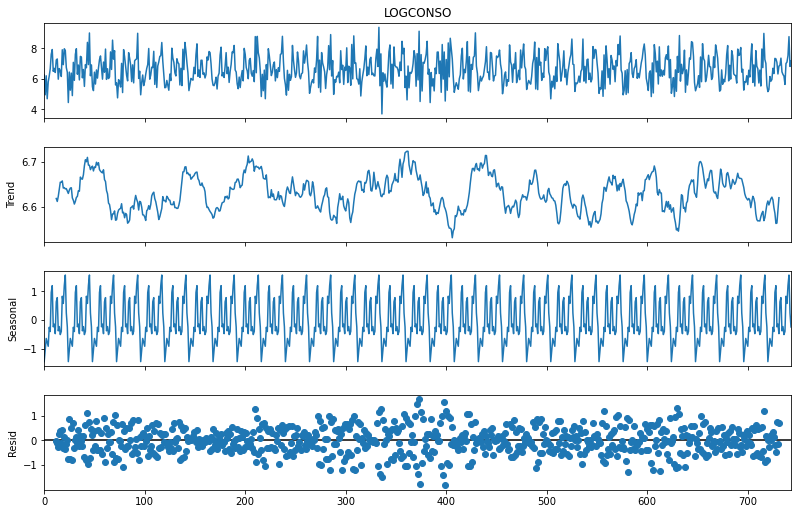

In [196]:


Decomp = sm.tsa.seasonal_decompose(EDF.LOGCONSO, model='additive', period=24)  # Modèle additif

plotd1 = Decomp.plot()
plt.gcf().set_size_inches(12, 8)  # Redimensionner la figure
plt.show() 

In [197]:
Mean = EDF.LOGCONSO.mean()
EDF["LC_res"] = EDF.LOGCONSO -Decomp.seasonal -Mean

fig = px.line(EDF, x='DATE', y="LC_res", labels={'DATE': 'Date', 'LC_res': 'Résidu '})
fig.update_layout(title="Log-consommation d'énergie du foyer centrée et sans composante périodique")
fig.show()


/home/ibotcazou/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

